In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
# from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


2022-08-25 12:44:28.833423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 12:44:28.833462: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01


In [6]:
import cv2

Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

Вот так загружаем с локального диска

In [7]:
from google.colab import files

uploaded = files.upload()



ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!ls

Открываем архив (это зависит от архива)

In [8]:
!pip install rarfile

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

labels/00_000200.png 19401
labels/00_000400.png 14502
labels/00_000600.png 19818
labels/00_000800.png 13554
labels/00_001000.png 14496
labels/00_001200.png 17371
labels/00_001400.png 12431
labels/00_001600.png 16390
labels/00_001800.png 16646
labels/00_002000.png 14844
labels/00_002200.png 14011
labels/00_002400.png 16921
labels/00_002600.png 15822
labels/00_002800.png 13681
labels/00_003000.png 13980
labels/00_003200.png 15122
labels/00_003400.png 13978
images/00_000200.png 791603
images/00_000400.png 816531
images/00_000600.png 862976
images/00_000800.png 836923
images/00_001000.png 829576
images/00_001200.png 822001
images/00_001400.png 858981
images/00_001600.png 797385
images/00_001800.png 850589
images/00_002000.png 818966
images/00_002200.png 641760
images/00_002400.png 714888
images/00_002600.png 774166
images/00_002800.png 890605
images/00_003000.png 837876
images/00_003200.png 755342
images/00_003400.png 695524
labels/ 0
images/ 0


In [ ]:
!ls

А вот так загрузим картинки с Гугл Диска (делаем только один вариант загрузки)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Прочитаем списки наших файлов (проверить идентичность, если имена одинаковые или собрать порядок чтения любым доступным способом)

Задаю маршрут для чтения

In [10]:
PAHT_label = './labels/'
PAHT_image = './images/'
  

In [11]:
import os, fnmatch
imag = os.listdir(PAHT_label)
imag_label = os.listdir(PAHT_image)

In [12]:
imag,imag_label

(['00_001400.png',
  '00_000400.png',
  '00_000200.png',
  '00_002800.png',
  '00_001600.png',
  '00_002000.png',
  '00_002200.png',
  '00_001000.png',
  '00_003400.png',
  '00_003200.png',
  '00_002400.png',
  '00_003000.png',
  '00_002600.png',
  '00_000600.png',
  '00_000800.png',
  '00_001800.png',
  '00_001200.png'],
 ['00_001400.png',
  '00_000400.png',
  '00_000200.png',
  '00_002800.png',
  '00_001600.png',
  '00_002000.png',
  '00_002200.png',
  '00_001000.png',
  '00_003400.png',
  '00_003200.png',
  '00_002400.png',
  '00_003000.png',
  '00_002600.png',
  '00_000600.png',
  '00_000800.png',
  '00_001800.png',
  '00_001200.png'])

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [13]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))


Посмотрели на входные кадры

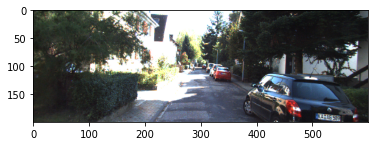

In [14]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

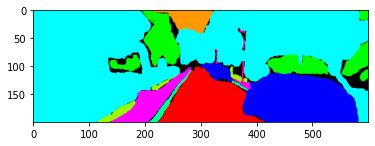

In [15]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [16]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [17]:
print(xTrain_Test.shape)

(17, 200, 600, 3)


Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Name	(r,g,b)	    7-Class mapping

Car	  ( 0, 0,255)	Object

Road	(255, 0, 0)	Road

Mark	(255,255, 0)	Road

Building	( 0,255, 0)	Building

Sidewalk	(255, 0,255)	Road

Tree/Bush	( 0,255,255)	Tree/Bush

Pole	(255, 0,153)	Sign/Pole

Sign	(153, 0,255)	Sign/Pole

Person	( 0,153,255)	Object

Wall	(153,255, 0)	Building

Sky	(255,153, 0)	Sky

Curb	( 0,255,153)	Road

Grass/Dirt	( 0,153,153)	Grass/Dirt

Void	( 0, 0, 0)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

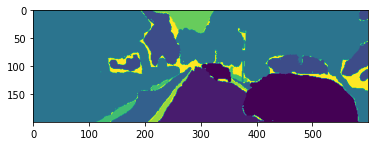

In [18]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


In [20]:
np.sum(cat_yi[100:,:100,1] )

0.0

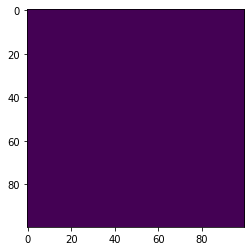

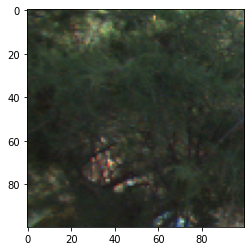

In [21]:
plt.imshow(cat_yi[:100,:100,3])
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.show()

In [22]:
cat_yi.shape

(200, 600, 14)

Сегментированную картинку в  One hot encoding (разметка на 14 классов)**

In [23]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [24]:
print(yTrain_Test.shape)

(17, 200, 600, 14)


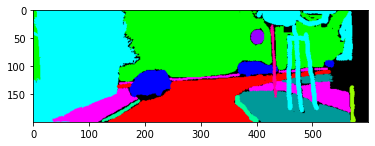

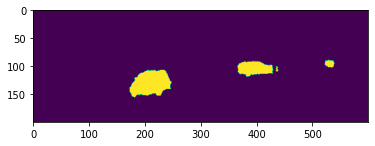

In [25]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [26]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [27]:
yTest.shape

(2, 200, 600, 14)

In [28]:
print(xTrain.shape)
print(yTrain.shape)

(15, 200, 600, 3)
(15, 200, 600, 14)


#Создаём и обучаем U-net

In [29]:
from tensorflow.keras.utils import plot_model

**Unet**

In [30]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [31]:
modelC = Unet(14, (200, 600, 3))

plot_model(modelC, to_file='modelC.png')

2022-08-25 12:52:47.620441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 12:52:47.620802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mrb/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-25 12:52:47.620906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mrb/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-25 12:52:47.620985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublas

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 600, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 600, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

                                                                                                  
 block4_conv2 (Conv2D)          (None, 25, 75, 512)  2359808     ['activation_7[0][0]']           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 25, 75, 512)  2048       ['block4_conv2[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 25, 75, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 block4_conv3 (Conv2D)          (None, 25, 75, 512)  2359808     ['activation_8[0][0]']           
                                                                                                  
 batch_nor

                                8)                                'activation_1[0][0]']           
                                                                                                  
 conv2d_4 (Conv2D)              (None, 200, 600, 64  73792       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 200, 600, 64  256        ['conv2d_4[0][0]']               
 ormalization)                  )                                                                 
                                                                                                  
 activation_17 (Activation)     (None, 200, 600, 64  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
          

In [32]:

history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

2022-08-25 12:52:49.254843: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 100800000 exceeds 10% of free system memory.


Epoch 1/10


2022-08-25 12:52:55.364463: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 61440000 exceeds 10% of free system memory.
2022-08-25 12:52:55.933113: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 276480000 exceeds 10% of free system memory.
2022-08-25 12:52:55.934928: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 276480000 exceeds 10% of free system memory.
2022-08-25 12:52:56.545986: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 276480000 exceeds 10% of free system memory.


15/15 [==============================] - 125s 8s/step - loss: 2.0481 - dice_coef: 0.2296 - val_loss: 548.6152 - val_dice_coef: 0.2661
Epoch 2/10
15/15 [==============================] - 98s 7s/step - loss: 1.5995 - dice_coef: 0.3122 - val_loss: 2983.8916 - val_dice_coef: 0.2657
Epoch 3/10
15/15 [==============================] - 98s 7s/step - loss: 1.4849 - dice_coef: 0.3432 - val_loss: 990.6782 - val_dice_coef: 0.2667
Epoch 4/10
15/15 [==============================] - 98s 7s/step - loss: 1.4910 - dice_coef: 0.3473 - val_loss: 473.6955 - val_dice_coef: 0.2657
Epoch 5/10
15/15 [==============================] - 98s 7s/step - loss: 1.3965 - dice_coef: 0.3582 - val_loss: 19.7594 - val_dice_coef: 0.3036
Epoch 6/10
15/15 [==============================] - 97s 7s/step - loss: 1.3427 - dice_coef: 0.3836 - val_loss: 10.0874 - val_dice_coef: 0.2947
Epoch 7/10
15/15 [==============================] - 97s 7s/step - loss: 1.3207 - dice_coef: 0.4025 - val_loss: 8.7231 - val_dice_coef: 0.3189
Epoch

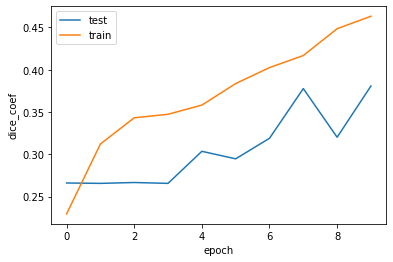

In [33]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [34]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
15/15 [==============================] - 95s 6s/step - loss: 1.1386 - dice_coef: 0.4852 - val_loss: 1.6512 - val_dice_coef: 0.3875
Epoch 2/10
15/15 [==============================] - 95s 6s/step - loss: 1.1185 - dice_coef: 0.4787 - val_loss: 6.4006 - val_dice_coef: 0.4581
Epoch 3/10
15/15 [==============================] - 96s 6s/step - loss: 1.1066 - dice_coef: 0.5007 - val_loss: 43.7885 - val_dice_coef: 0.2998
Epoch 4/10
15/15 [==============================] - 94s 6s/step - loss: 1.0340 - dice_coef: 0.5022 - val_loss: 11.3402 - val_dice_coef: 0.3459
Epoch 5/10
15/15 [==============================] - 95s 6s/step - loss: 1.0362 - dice_coef: 0.5118 - val_loss: 3.1612 - val_dice_coef: 0.3740
Epoch 6/10
15/15 [==============================] - 94s 6s/step - loss: 0.9350 - dice_coef: 0.5516 - val_loss: 2.5994 - val_dice_coef: 0.4112
Epoch 7/10
15/15 [==============================] - 94s 6s/step - loss: 0.8812 - dice_coef: 0.5678 - val_loss: 2.1904 - val_dice_coef: 0.4328
Epoc

In [35]:
pred = modelC.predict(xTest)
print(pred.shape)

1/1 [==============================] - 3s 3s/step
(2, 200, 600, 14)


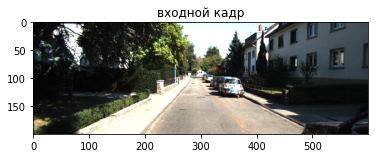

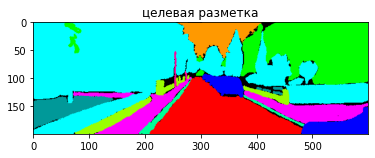

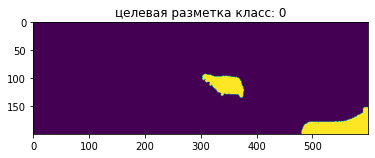

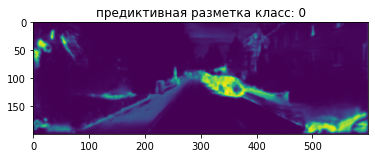

In [36]:
n = 1
class_ =0
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

**Претренированная  Unet**

In [37]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 29s 0us/step


In [38]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 150, 128)      0     

In [39]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [40]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [41]:
modelU = unet_pre_train(num_classes = 14, input_shape= (200, 600, 3))

plot_model(modelU, to_file='modelU.png')

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 75, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 150, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 300, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                       

                                                                                                  
 conv2d_10 (Conv2D)             (None, 50, 150, 128  147584      ['activation_22[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 50, 150, 128  512        ['conv2d_10[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_23 (Activation)     (None, 50, 150, 128  0           ['batch_normalization_23[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_tr

In [42]:
from IPython.display import clear_output

In [43]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])

    k = Ipred.shape[3]
    if k>4:
      k = 4
    print('Predict')
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(yTest[0,:,:,i])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/40
5/5 [==============================] - ETA: 0s - loss: 2.3152 - dice_coef: 0.1405Predict


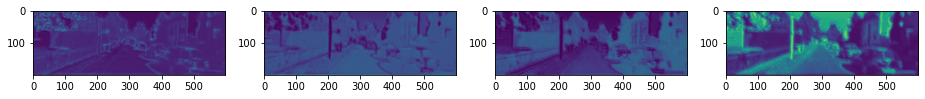

True


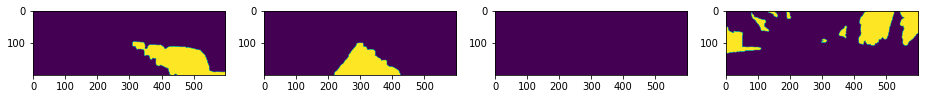


Sample Prediction after epoch 1

5/5 [==============================] - 39s 8s/step - loss: 2.3152 - dice_coef: 0.1405 - val_loss: 2.2378 - val_dice_coef: 0.1715
Epoch 2/40
5/5 [==============================] - ETA: 0s - loss: 1.6580 - dice_coef: 0.3115Predict


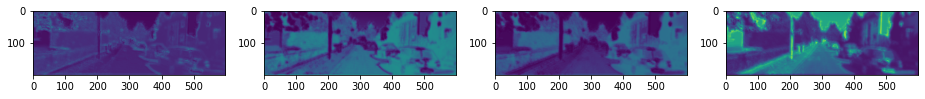

True


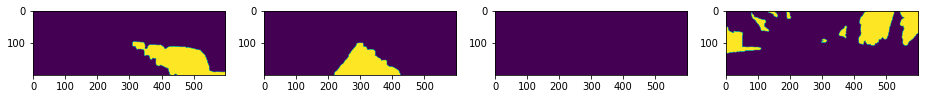


Sample Prediction after epoch 2

5/5 [==============================] - 36s 8s/step - loss: 1.6580 - dice_coef: 0.3115 - val_loss: 2.1377 - val_dice_coef: 0.1875
Epoch 3/40
5/5 [==============================] - ETA: 0s - loss: 1.5636 - dice_coef: 0.3618Predict


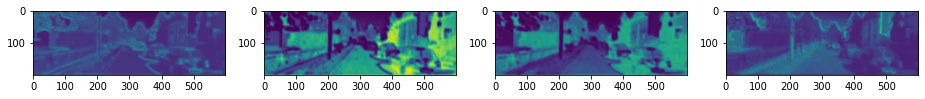

True


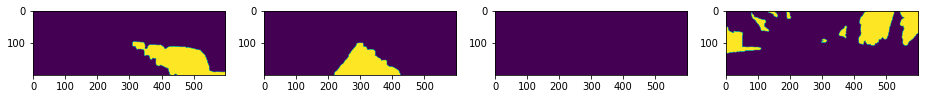


Sample Prediction after epoch 3

5/5 [==============================] - 36s 8s/step - loss: 1.5636 - dice_coef: 0.3618 - val_loss: 2.1950 - val_dice_coef: 0.1614
Epoch 4/40
5/5 [==============================] - ETA: 0s - loss: 1.4058 - dice_coef: 0.3723Predict


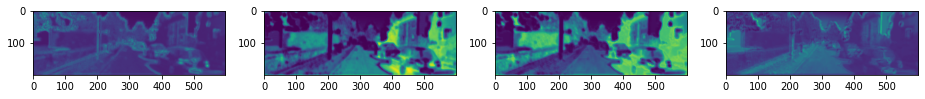

True


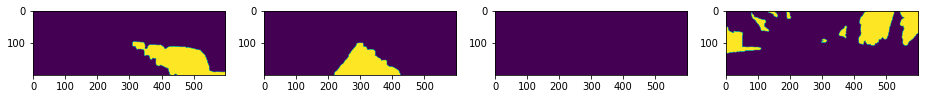


Sample Prediction after epoch 4

5/5 [==============================] - 37s 8s/step - loss: 1.4058 - dice_coef: 0.3723 - val_loss: 2.1999 - val_dice_coef: 0.1634
Epoch 5/40
5/5 [==============================] - ETA: 0s - loss: 1.3279 - dice_coef: 0.3965Predict


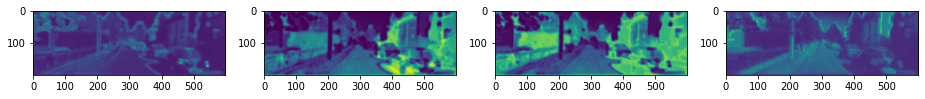

True


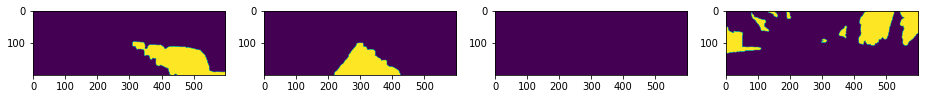


Sample Prediction after epoch 5

5/5 [==============================] - 37s 8s/step - loss: 1.3279 - dice_coef: 0.3965 - val_loss: 2.1285 - val_dice_coef: 0.1673
Epoch 6/40
5/5 [==============================] - ETA: 0s - loss: 1.2727 - dice_coef: 0.4246Predict


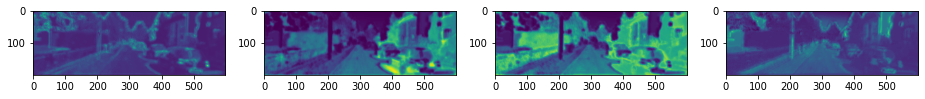

True


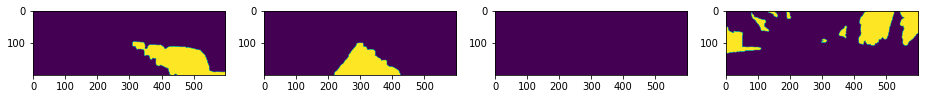


Sample Prediction after epoch 6

5/5 [==============================] - 37s 8s/step - loss: 1.2727 - dice_coef: 0.4246 - val_loss: 2.0708 - val_dice_coef: 0.1728
Epoch 7/40
5/5 [==============================] - ETA: 0s - loss: 1.2442 - dice_coef: 0.4377Predict


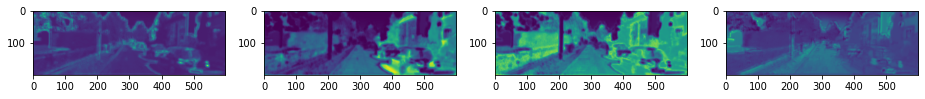

True


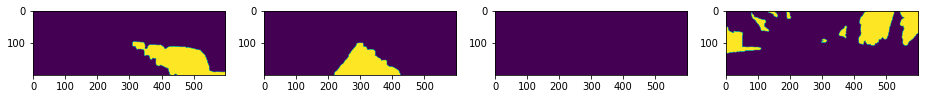


Sample Prediction after epoch 7

5/5 [==============================] - 37s 8s/step - loss: 1.2442 - dice_coef: 0.4377 - val_loss: 2.0797 - val_dice_coef: 0.1692
Epoch 8/40
5/5 [==============================] - ETA: 0s - loss: 1.2144 - dice_coef: 0.4344Predict


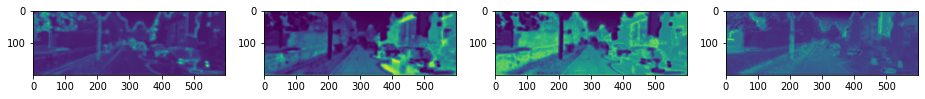

True


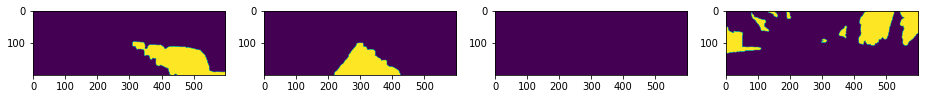


Sample Prediction after epoch 8

5/5 [==============================] - 37s 8s/step - loss: 1.2144 - dice_coef: 0.4344 - val_loss: 2.0346 - val_dice_coef: 0.1704
Epoch 9/40
5/5 [==============================] - ETA: 0s - loss: 1.1678 - dice_coef: 0.4716Predict


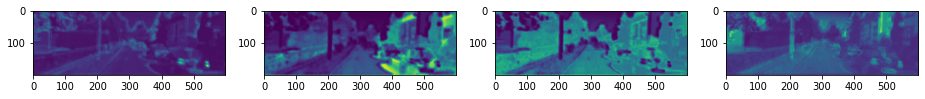

True


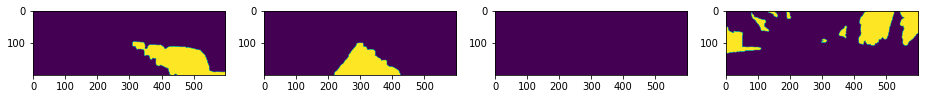


Sample Prediction after epoch 9

5/5 [==============================] - 37s 8s/step - loss: 1.1678 - dice_coef: 0.4716 - val_loss: 1.9473 - val_dice_coef: 0.1791
Epoch 10/40
5/5 [==============================] - ETA: 0s - loss: 1.1047 - dice_coef: 0.4794Predict


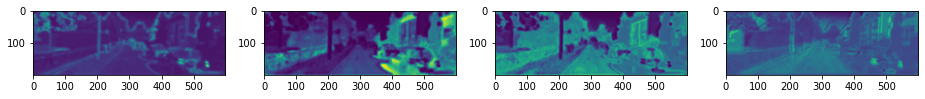

True


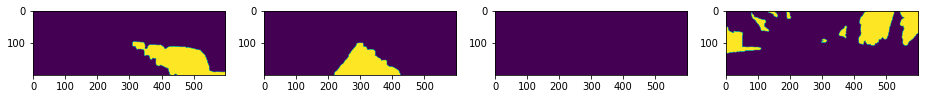


Sample Prediction after epoch 10

5/5 [==============================] - 37s 8s/step - loss: 1.1047 - dice_coef: 0.4794 - val_loss: 2.0021 - val_dice_coef: 0.1682
Epoch 11/40
5/5 [==============================] - ETA: 0s - loss: 1.0963 - dice_coef: 0.4982Predict


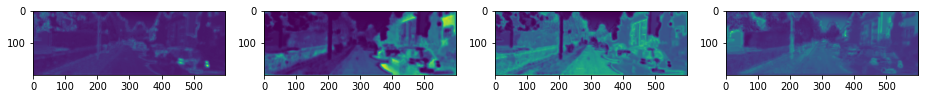

True


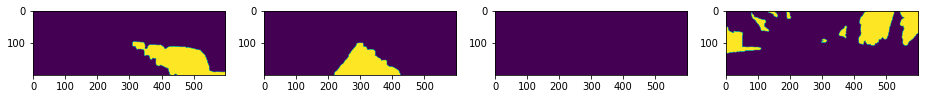


Sample Prediction after epoch 11

5/5 [==============================] - 37s 8s/step - loss: 1.0963 - dice_coef: 0.4982 - val_loss: 1.8742 - val_dice_coef: 0.1907
Epoch 12/40
5/5 [==============================] - ETA: 0s - loss: 1.0867 - dice_coef: 0.4922Predict


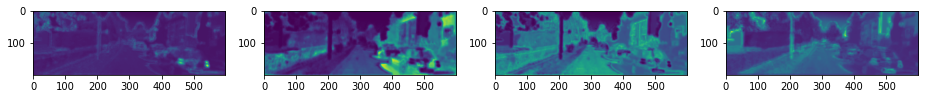

True


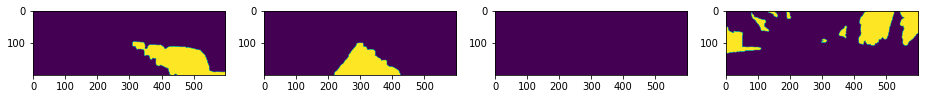


Sample Prediction after epoch 12

5/5 [==============================] - 37s 8s/step - loss: 1.0867 - dice_coef: 0.4922 - val_loss: 1.8605 - val_dice_coef: 0.1920
Epoch 13/40
5/5 [==============================] - ETA: 0s - loss: 1.0767 - dice_coef: 0.5020Predict


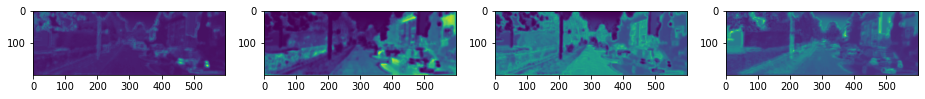

True


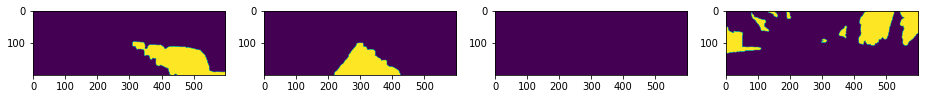


Sample Prediction after epoch 13

5/5 [==============================] - 37s 8s/step - loss: 1.0767 - dice_coef: 0.5020 - val_loss: 1.8193 - val_dice_coef: 0.1926
Epoch 14/40
5/5 [==============================] - ETA: 0s - loss: 1.0719 - dice_coef: 0.5035Predict


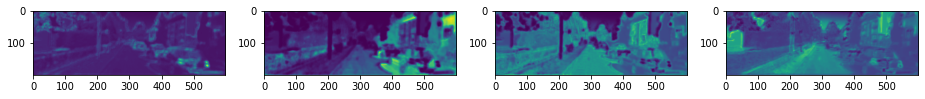

True


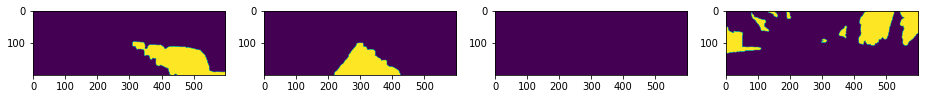


Sample Prediction after epoch 14

5/5 [==============================] - 37s 8s/step - loss: 1.0719 - dice_coef: 0.5035 - val_loss: 1.8251 - val_dice_coef: 0.1976
Epoch 15/40
5/5 [==============================] - ETA: 0s - loss: 0.9912 - dice_coef: 0.5308Predict


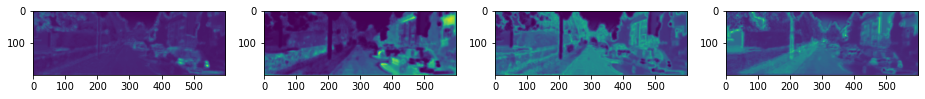

True


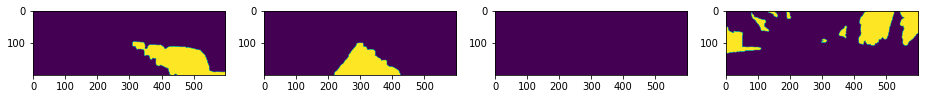


Sample Prediction after epoch 15

5/5 [==============================] - 37s 8s/step - loss: 0.9912 - dice_coef: 0.5308 - val_loss: 1.7729 - val_dice_coef: 0.2108
Epoch 16/40
5/5 [==============================] - ETA: 0s - loss: 1.0202 - dice_coef: 0.5239Predict


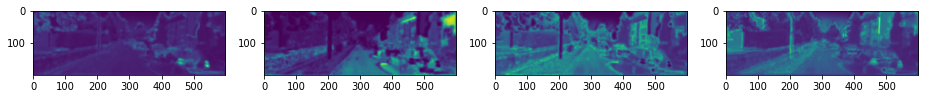

True


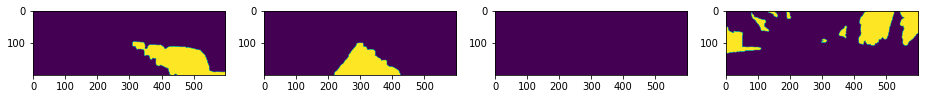


Sample Prediction after epoch 16

5/5 [==============================] - 37s 8s/step - loss: 1.0202 - dice_coef: 0.5239 - val_loss: 1.6634 - val_dice_coef: 0.2300
Epoch 17/40
5/5 [==============================] - ETA: 0s - loss: 0.9782 - dice_coef: 0.5559Predict


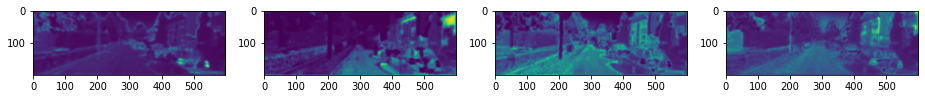

True


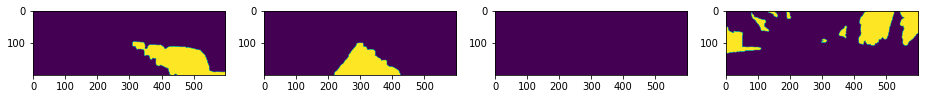


Sample Prediction after epoch 17

5/5 [==============================] - 37s 8s/step - loss: 0.9782 - dice_coef: 0.5559 - val_loss: 1.5988 - val_dice_coef: 0.2606
Epoch 18/40
5/5 [==============================] - ETA: 0s - loss: 0.9251 - dice_coef: 0.5656Predict


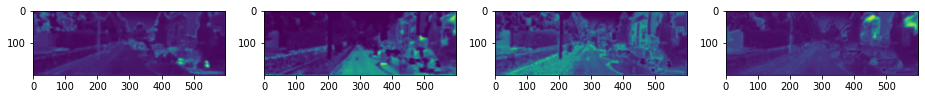

True


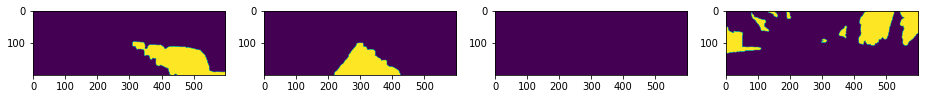


Sample Prediction after epoch 18

5/5 [==============================] - 37s 8s/step - loss: 0.9251 - dice_coef: 0.5656 - val_loss: 1.5070 - val_dice_coef: 0.2799
Epoch 19/40
5/5 [==============================] - ETA: 0s - loss: 0.8825 - dice_coef: 0.5767Predict


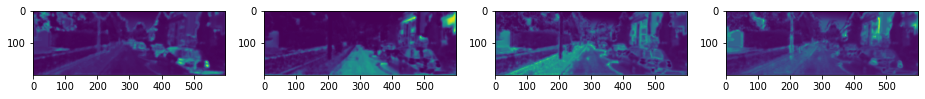

True


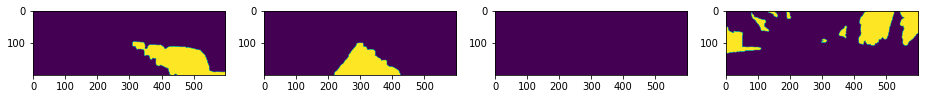


Sample Prediction after epoch 19

5/5 [==============================] - 37s 8s/step - loss: 0.8825 - dice_coef: 0.5767 - val_loss: 1.4915 - val_dice_coef: 0.2987
Epoch 20/40
5/5 [==============================] - ETA: 0s - loss: 0.9096 - dice_coef: 0.5758Predict


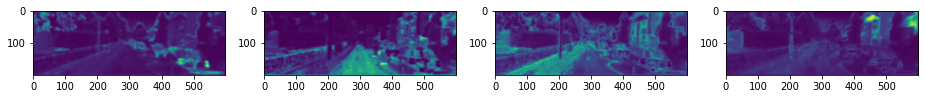

True


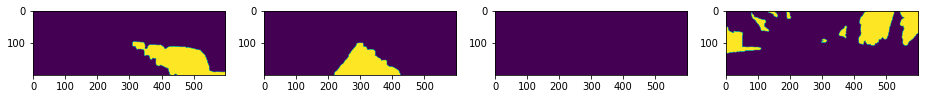


Sample Prediction after epoch 20

5/5 [==============================] - 37s 8s/step - loss: 0.9096 - dice_coef: 0.5758 - val_loss: 1.4395 - val_dice_coef: 0.3061
Epoch 21/40
5/5 [==============================] - ETA: 0s - loss: 0.8773 - dice_coef: 0.5919Predict


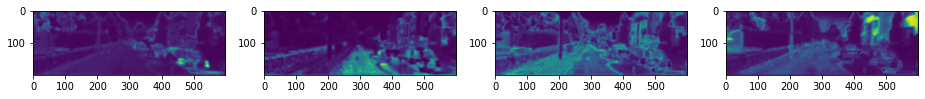

True


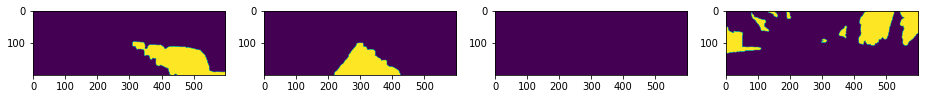


Sample Prediction after epoch 21

5/5 [==============================] - 37s 8s/step - loss: 0.8773 - dice_coef: 0.5919 - val_loss: 1.3458 - val_dice_coef: 0.3395
Epoch 22/40
5/5 [==============================] - ETA: 0s - loss: 0.9278 - dice_coef: 0.5791Predict


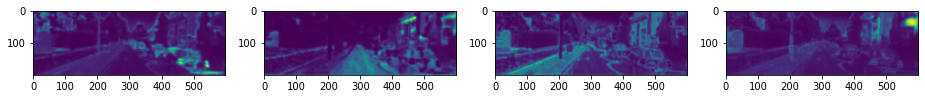

True


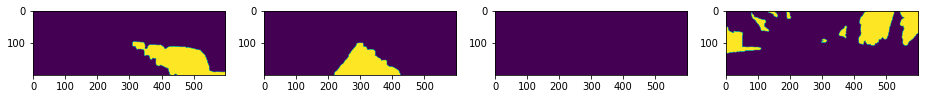


Sample Prediction after epoch 22

5/5 [==============================] - 37s 8s/step - loss: 0.9278 - dice_coef: 0.5791 - val_loss: 1.3934 - val_dice_coef: 0.3270
Epoch 23/40
5/5 [==============================] - ETA: 0s - loss: 0.8419 - dice_coef: 0.5948Predict


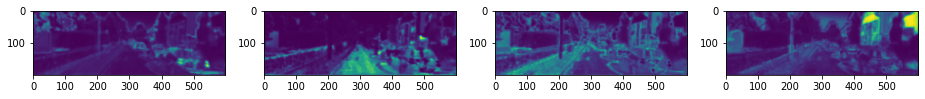

True


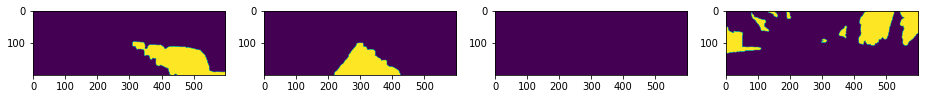


Sample Prediction after epoch 23

5/5 [==============================] - 37s 8s/step - loss: 0.8419 - dice_coef: 0.5948 - val_loss: 1.2285 - val_dice_coef: 0.3719
Epoch 24/40
5/5 [==============================] - ETA: 0s - loss: 0.8653 - dice_coef: 0.5991Predict


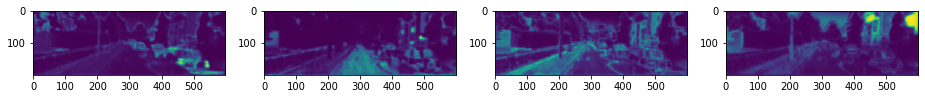

True


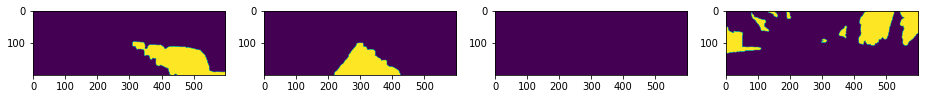


Sample Prediction after epoch 24

5/5 [==============================] - 37s 8s/step - loss: 0.8653 - dice_coef: 0.5991 - val_loss: 1.2314 - val_dice_coef: 0.3899
Epoch 25/40
5/5 [==============================] - ETA: 0s - loss: 0.8271 - dice_coef: 0.5992Predict


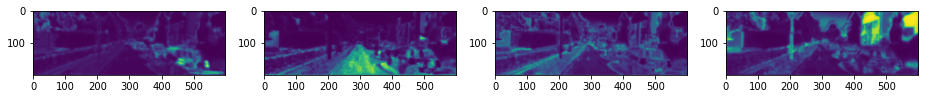

True


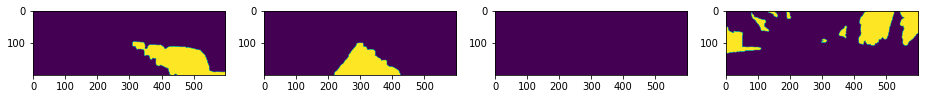


Sample Prediction after epoch 25

5/5 [==============================] - 36s 8s/step - loss: 0.8271 - dice_coef: 0.5992 - val_loss: 1.1142 - val_dice_coef: 0.4240
Epoch 26/40
5/5 [==============================] - ETA: 0s - loss: 0.8124 - dice_coef: 0.6155Predict


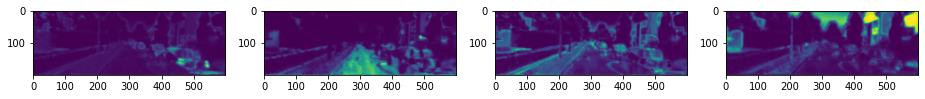

True


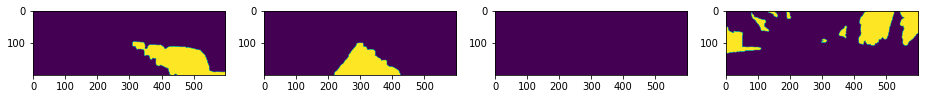


Sample Prediction after epoch 26

5/5 [==============================] - 37s 8s/step - loss: 0.8124 - dice_coef: 0.6155 - val_loss: 1.1272 - val_dice_coef: 0.4437
Epoch 27/40
5/5 [==============================] - ETA: 0s - loss: 0.8253 - dice_coef: 0.6178Predict


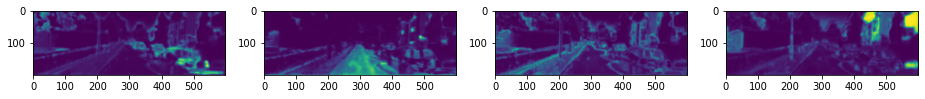

True


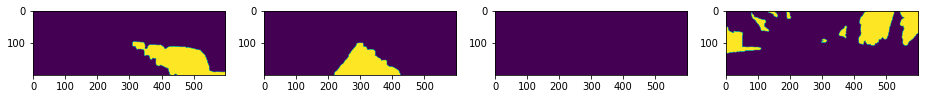


Sample Prediction after epoch 27

5/5 [==============================] - 37s 8s/step - loss: 0.8253 - dice_coef: 0.6178 - val_loss: 1.1063 - val_dice_coef: 0.4403
Epoch 28/40
5/5 [==============================] - ETA: 0s - loss: 0.8145 - dice_coef: 0.6143Predict


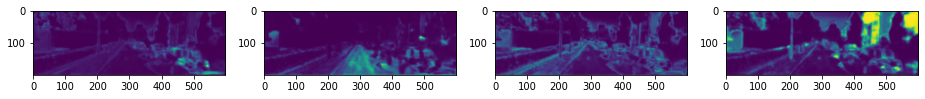

True


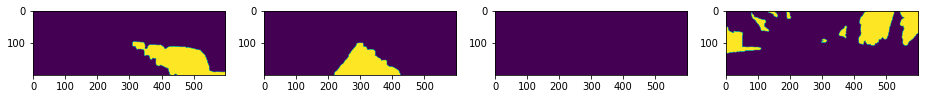


Sample Prediction after epoch 28

5/5 [==============================] - 36s 8s/step - loss: 0.8145 - dice_coef: 0.6143 - val_loss: 0.9840 - val_dice_coef: 0.4907
Epoch 29/40
5/5 [==============================] - ETA: 0s - loss: 0.7751 - dice_coef: 0.6311Predict


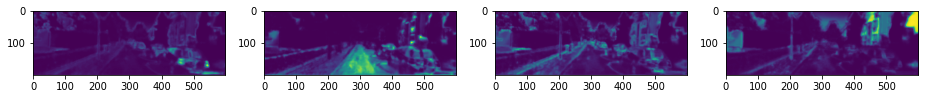

True


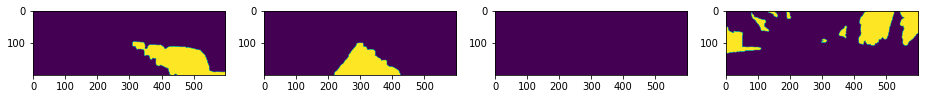


Sample Prediction after epoch 29

5/5 [==============================] - 37s 8s/step - loss: 0.7751 - dice_coef: 0.6311 - val_loss: 1.1474 - val_dice_coef: 0.4493
Epoch 30/40
5/5 [==============================] - ETA: 0s - loss: 0.7707 - dice_coef: 0.6393Predict


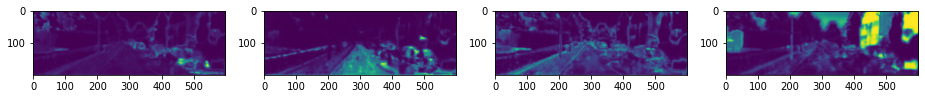

True


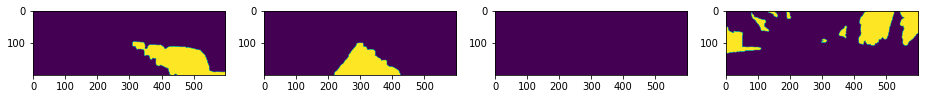


Sample Prediction after epoch 30

5/5 [==============================] - 37s 8s/step - loss: 0.7707 - dice_coef: 0.6393 - val_loss: 0.9554 - val_dice_coef: 0.5134
Epoch 31/40
5/5 [==============================] - ETA: 0s - loss: 0.7846 - dice_coef: 0.6298Predict


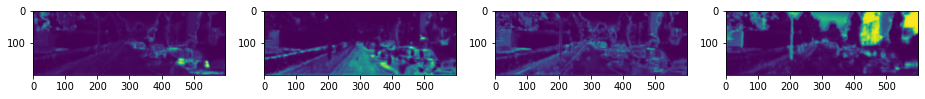

True


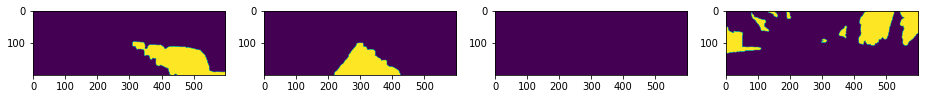


Sample Prediction after epoch 31

5/5 [==============================] - 37s 8s/step - loss: 0.7846 - dice_coef: 0.6298 - val_loss: 0.9866 - val_dice_coef: 0.4927
Epoch 32/40
5/5 [==============================] - ETA: 0s - loss: 0.7579 - dice_coef: 0.6424Predict


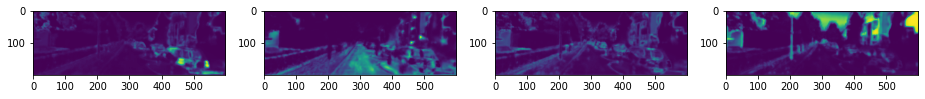

True


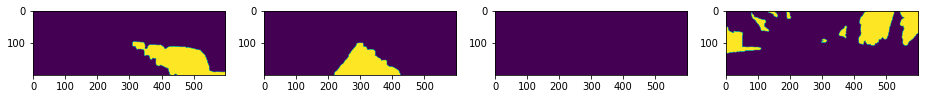


Sample Prediction after epoch 32

5/5 [==============================] - 37s 8s/step - loss: 0.7579 - dice_coef: 0.6424 - val_loss: 1.0726 - val_dice_coef: 0.4746
Epoch 33/40
5/5 [==============================] - ETA: 0s - loss: 0.7954 - dice_coef: 0.6204Predict


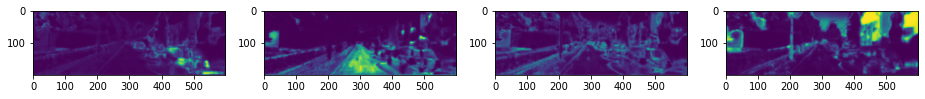

True


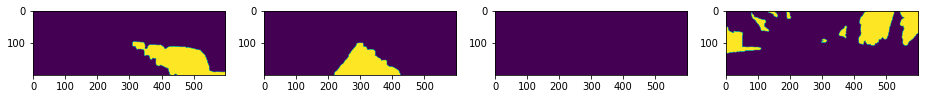


Sample Prediction after epoch 33

5/5 [==============================] - 37s 8s/step - loss: 0.7954 - dice_coef: 0.6204 - val_loss: 0.9371 - val_dice_coef: 0.5119
Epoch 34/40
5/5 [==============================] - ETA: 0s - loss: 0.7713 - dice_coef: 0.6393Predict


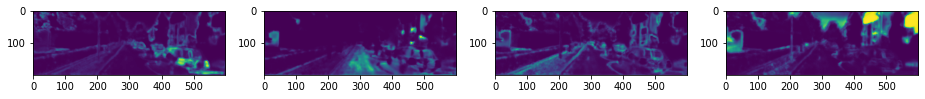

True


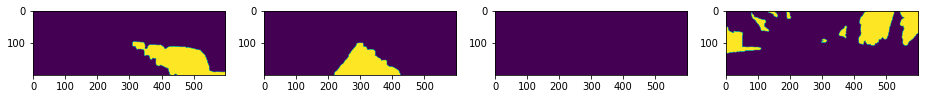


Sample Prediction after epoch 34

5/5 [==============================] - 37s 8s/step - loss: 0.7713 - dice_coef: 0.6393 - val_loss: 0.9659 - val_dice_coef: 0.5157
Epoch 35/40
5/5 [==============================] - ETA: 0s - loss: 0.7271 - dice_coef: 0.6492Predict


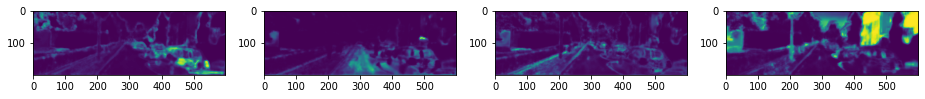

True


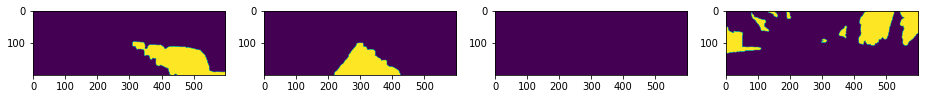


Sample Prediction after epoch 35

5/5 [==============================] - 37s 8s/step - loss: 0.7271 - dice_coef: 0.6492 - val_loss: 0.8754 - val_dice_coef: 0.5573
Epoch 36/40
5/5 [==============================] - ETA: 0s - loss: 0.6986 - dice_coef: 0.6671Predict


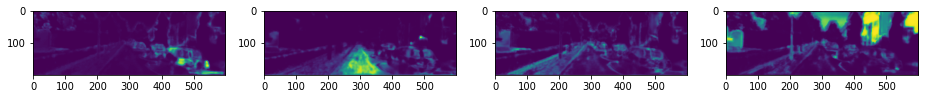

True


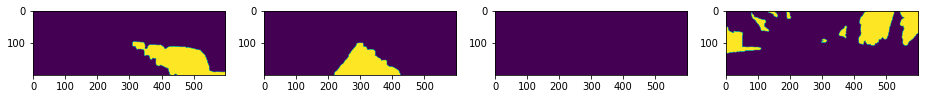


Sample Prediction after epoch 36

5/5 [==============================] - 37s 8s/step - loss: 0.6986 - dice_coef: 0.6671 - val_loss: 0.8984 - val_dice_coef: 0.5647
Epoch 37/40
5/5 [==============================] - ETA: 0s - loss: 0.6965 - dice_coef: 0.6613Predict


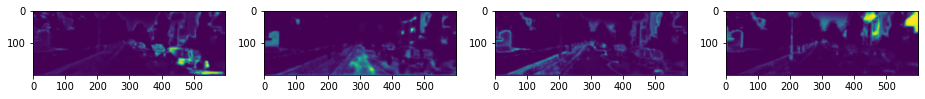

True


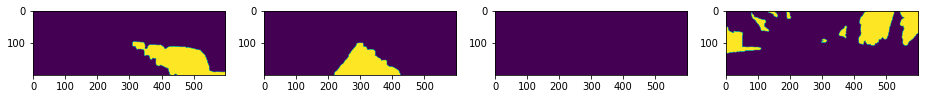


Sample Prediction after epoch 37

5/5 [==============================] - 37s 8s/step - loss: 0.6965 - dice_coef: 0.6613 - val_loss: 1.2346 - val_dice_coef: 0.4837
Epoch 38/40
5/5 [==============================] - ETA: 0s - loss: 0.7087 - dice_coef: 0.6607Predict


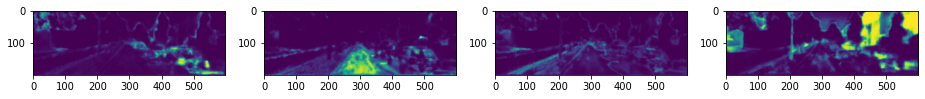

True


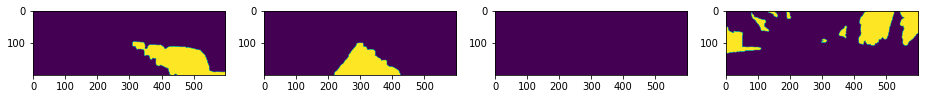


Sample Prediction after epoch 38

5/5 [==============================] - 37s 8s/step - loss: 0.7087 - dice_coef: 0.6607 - val_loss: 0.8042 - val_dice_coef: 0.6002
Epoch 39/40
5/5 [==============================] - ETA: 0s - loss: 0.6594 - dice_coef: 0.6746Predict


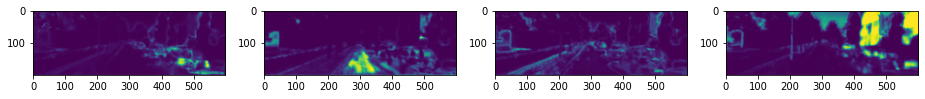

True


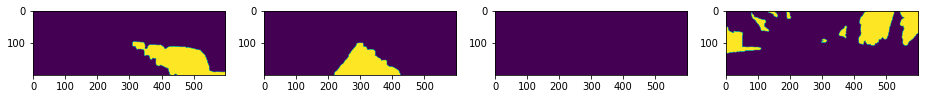


Sample Prediction after epoch 39

5/5 [==============================] - 37s 8s/step - loss: 0.6594 - dice_coef: 0.6746 - val_loss: 0.8669 - val_dice_coef: 0.5751
Epoch 40/40
5/5 [==============================] - ETA: 0s - loss: 0.6422 - dice_coef: 0.6851Predict


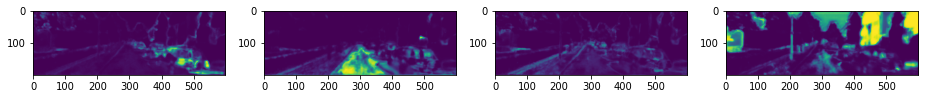

True


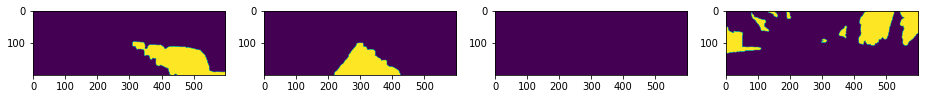


Sample Prediction after epoch 40

5/5 [==============================] - 37s 8s/step - loss: 0.6422 - dice_coef: 0.6851 - val_loss: 0.7587 - val_dice_coef: 0.6241


In [44]:
history = modelU.fit(xTrain, yTrain, epochs=40, batch_size=3, validation_data=(xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 ), DisplayCallback()])

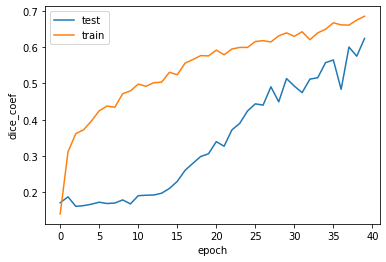

In [45]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

#Распознаём обучающую выборку

In [46]:
predu = modelU.predict(xTest)
print(predu.shape)


1/1 [==============================] - 2s 2s/step
(2, 200, 600, 14)


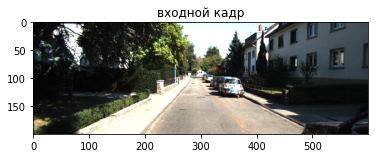

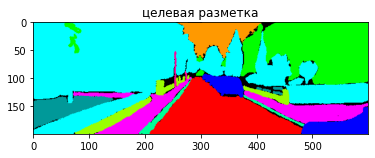

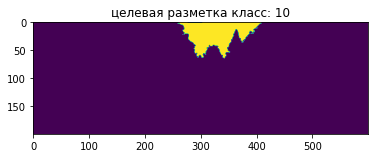

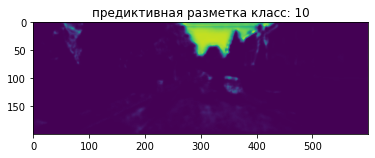

In [47]:
n = 1
class_ = 10
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()


Что еще делаем:

- аугментацию
- ищем новые примеры
- проверяем разметку
- меняем модель